In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
# ==============================
# Cataract vs Normal – Model Zoo
# DenseNet201 • EfficientNetV2-S • ConvNeXt-Small • Swin-Tiny • CoAtNet-0
# ==============================


import os, math, itertools, numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# -----------------------------
# Config
# -----------------------------
DATA_DIR = "/content/drive/MyDrive/processed_images"  # <<< CHANGE THIS
IMG_SIZE = 256
BATCH_SIZE = 32
EPOCHS_HEAD = 10        # head training (frozen backbone)
EPOCHS_FT = 10          # fine-tuning
VAL_SPLIT = 0.2
SEED = 42
NUM_CLASSES = 1         # binary sigmoid
OUTPUT_DIR = "/content/drive/MyDrive/outputs_cataract/train/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

AUTOTUNE = tf.data.AUTOTUNE

# -----------------------------
# Data pipeline (tf.data)
# -----------------------------
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    validation_split=VAL_SPLIT,
    subset="training",
    seed=SEED,
    label_mode="binary",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    validation_split=VAL_SPLIT,
    subset="validation",
    seed=SEED,
    label_mode="binary",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
)

# Cache & prefetch
def configure(ds, training=False):
    ds = ds.cache()
    if training:
        ds = ds.shuffle(1000, seed=SEED)
    return ds.prefetch(AUTOTUNE)

# Light augmentations
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.05, 0.05),
], name="augmentation")

# Add rescaling (consistent across backbones)
rescale = layers.Rescaling(1./255)

train_ds = configure(train_ds.map(lambda x, y: (rescale(x), y)), training=True)
val_ds   = configure(val_ds.map(lambda x, y: (rescale(x), y)), training=False)

# Class weights (handle imbalance)
# Estimate counts from the training dataset
y_counts = {0:0, 1:0}
for _, yb in train_ds.take(1000):  # bounded pass for speed
    # yb shape (B,1)
    vals, counts = np.unique(yb.numpy().astype(int), return_counts=True)
    for v, c in zip(vals, counts):
        y_counts[int(v)] += int(c)

if y_counts[0] == 0 or y_counts[1] == 0:
    class_weight = None
else:
    total = y_counts[0] + y_counts[1]
    class_weight = {
        0: total / (2.0 * y_counts[0]),
        1: total / (2.0 * y_counts[1]),
    }
print("Class counts:", y_counts, "→ class_weight:", class_weight)

# -----------------------------
# Backbones
# -----------------------------
from tensorflow.keras.applications import (
    DenseNet201,
    EfficientNetV2S,
    ConvNeXtSmall,
)

# Swin & CoAtNet from keras-cv-attention-models
from keras_cv_attention_models import swin_transformer, coatnet

def make_backbone(model_name, input_shape):
    """
    Returns (backbone, preprocess_note)
    """
    if model_name == "DenseNet201":
        bb = DenseNet201(include_top=False, weights="imagenet", input_shape=input_shape)
    elif model_name == "EfficientNetV2S":
        bb = EfficientNetV2S(include_top=False, weights="imagenet", input_shape=input_shape)
    elif model_name == "ConvNeXtSmall":
        bb = ConvNeXtSmall(include_top=False, weights="imagenet", input_shape=input_shape)
    elif model_name == "Swin_Tiny":
        # default: window size 7, patch size 4; accepts 256x256 nicely
        bb = swin_transformer.SwinTransformerTiny(
            include_top=False, input_shape=input_shape, pretrained="imagenet"
        )
    elif model_name == "CoAtNet0":
        bb = coatnet.CoAtNet0(
            include_top=False, input_shape=input_shape, pretrained="imagenet"
        )
    else:
        raise ValueError("Unknown model name")
    return bb

# -----------------------------
# Model builder
# -----------------------------
def build_classifier(model_name, input_shape=(IMG_SIZE, IMG_SIZE, 3), dropout=0.4):
    backbone = make_backbone(model_name, input_shape)
    backbone.trainable = False  # start frozen

    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)           # aug
    x = backbone(x, training=False)         # frozen forward
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs, name=f"{model_name}_clf")
    return model, backbone

# -----------------------------
# Train & Fine-tune helpers
# -----------------------------
def compile_model(model, lr=1e-3):
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            keras.metrics.AUC(name="auc"),
            keras.metrics.Precision(name="precision"),
            keras.metrics.Recall(name="recall"),
        ]
    )

def train_two_stage(model_name):
    model, backbone = build_classifier(model_name)
    ckpt_path = os.path.join(OUTPUT_DIR, f"{model_name}_best.h5")

    callbacks = [
        EarlyStopping(monitor="val_auc", mode="max", patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_auc", mode="max", factor=0.5, patience=2, min_lr=1e-6, verbose=1),
        ModelCheckpoint(ckpt_path, monitor="val_auc", mode="max", save_best_only=True, verbose=1),
    ]

    # Stage 1: train head
    compile_model(model, lr=1e-3)
    hist1 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS_HEAD,
        class_weight=class_weight,
        callbacks=callbacks,
        verbose=1
    )

    # Stage 2: fine-tune last ~30% layers of backbone
    backbone.trainable = True
    # set fine-tune boundary
    ft_at = int(len(backbone.layers) * 0.7)
    for i, layer in enumerate(backbone.layers):
        layer.trainable = (i >= ft_at)

    compile_model(model, lr=2e-4)
    hist2 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS_FT,
        class_weight=class_weight,
        callbacks=callbacks,
        verbose=1
    )

    # Load best and return histories + model
    model.load_weights(ckpt_path)
    return model, [hist1.history, hist2.history]

# -----------------------------
# Train all models
# -----------------------------
MODEL_NAMES = [
    "DenseNet201",
    "EfficientNetV2S",
    "ConvNeXtSmall",
    "Swin_Tiny",
    "CoAtNet0",
]

histories = {}
models = {}

for name in MODEL_NAMES:
    print("\n", "="*28, f"\nTraining: {name}\n", "="*28)
    model, h_list = train_two_stage(name)
    models[name] = model
    # merge histories end-to-end
    merged = {}
    for h in h_list:
        for k, v in h.items():
            merged.setdefault(k, [])
            merged[k].extend(v)
    histories[name] = merged

# -----------------------------
# Evaluation on validation set
# -----------------------------
def collect_preds(model, dataset):
    y_true, y_prob = [], []
    for xb, yb in dataset:
        p = model.predict(xb, verbose=0).ravel()
        y_prob.extend(p.tolist())
        y_true.extend(yb.numpy().ravel().tolist())
    y_true = np.array(y_true).astype(int)
    y_prob = np.array(y_prob)
    y_pred = (y_prob >= 0.5).astype(int)
    return y_true, y_prob, y_pred

final_metrics = {}
for name, model in models.items():
    y_true, y_prob, y_pred = collect_preds(model, val_ds)
    report = classification_report(y_true, y_pred, target_names=["normal","cataract"], digits=4, output_dict=True)
    cm = confusion_matrix(y_true, y_pred)
    acc = report["accuracy"]
    prec = report["weighted avg"]["precision"]
    rec = report["weighted avg"]["recall"]
    final_metrics[name] = {"accuracy": acc, "precision": prec, "recall": rec, "cm": cm, "report": report}

    # Save reports
    np.savetxt(os.path.join(OUTPUT_DIR, f"{name}_confusion_matrix.csv"), cm, fmt="%d", delimiter=",")
    # pretty text report
    with open(os.path.join(OUTPUT_DIR, f"{name}_classification_report.txt"), "w") as f:
        from pprint import pprint
        for k, v in report.items():
            print(k, v, file=f)

# -----------------------------
# Plots – performance graphs
# -----------------------------
# 1) Val Accuracy across epochs
plt.figure(figsize=(9,6))
for name, h in histories.items():
    if "val_accuracy" in h:
        plt.plot(h["val_accuracy"], label=name)
plt.title("Validation Accuracy per Epoch")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "val_accuracy_per_epoch.png"))
plt.show()

# 2) Val AUC across epochs
plt.figure(figsize=(9,6))
for name, h in histories.items():
    if "val_auc" in h:
        plt.plot(h["val_auc"], label=name)
plt.title("Validation AUC per Epoch")
plt.xlabel("Epoch"); plt.ylabel("AUC"); plt.legend(); plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "val_auc_per_epoch.png"))
plt.show()

# 3) Final metrics bar chart (Accuracy)
plt.figure(figsize=(9,6))
names = list(final_metrics.keys())
accs = [final_metrics[n]["accuracy"] for n in names]
plt.bar(names, accs)
plt.title("Final Validation Accuracy (by model)")
plt.ylabel("Accuracy"); plt.xticks(rotation=20); plt.ylim(0,1)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "final_accuracy_bar.png"))
plt.show()

# -----------------------------
# Print concise tables + confusion matrices
# -----------------------------
print("\n=== Final metrics (validation) ===")
for name in names:
    m = final_metrics[name]
    print(f"{name:16s} | Acc: {m['accuracy']:.4f} | Prec: {m['precision']:.4f} | Rec: {m['recall']:.4f}")

print("\n=== Confusion Matrices (rows=true, cols=pred) ===")
for name in names:
    cm = final_metrics[name]["cm"]
    print(f"\n{name}\n{cm}")


Found 612 files belonging to 2 classes.
Using 490 files for training.
Found 612 files belonging to 2 classes.
Using 122 files for validation.
Class counts: {0: 95, 1: 395} → class_weight: {0: 2.5789473684210527, 1: 0.620253164556962}


ModuleNotFoundError: No module named 'keras_cv_attention_models'

In [ ]:
!pip install tensorflow-addons
!pip install keras-cv-attention-models==1.3.8

ERROR: Could not find a version that satisfies the requirement tensorflow-addons (from versions: none)
ERROR: No matching distribution found for tensorflow-addons
  Using cached keras_cv_attention_models-1.3.8-py3-none-any.whl.metadata (129 kB)
INFO: pip is looking at multiple versions of keras-cv-attention-models to determine which version is compatible with other requirements. This could take a while.
ERROR: Could not find a version that satisfies the requirement tensorflow-addons; platform_machine != "aarch64" and platform_machine != "aarch32" (from keras-cv-attention-models) (from versions: none)
ERROR: No matching distribution found for tensorflow-addons; platform_machine != "aarch64" and platform_machine != "aarch32"


After running the cell above, please re-run the original code cell. The `ModuleNotFoundError` should be resolved. The error occurred because `keras-cv-attention-models` depends on `tensorflow-addons`, and `tensorflow-addons` was not found during the installation. Installing `tensorflow-addons` first resolves this dependency issue.

In [ ]:
!pip install tensorflow-addons==0.16.1
!pip install keras-cv-attention-models==1.3.8

ERROR: Could not find a version that satisfies the requirement tensorflow-addons==0.16.1 (from versions: none)
ERROR: No matching distribution found for tensorflow-addons==0.16.1
  Using cached keras_cv_attention_models-1.3.8-py3-none-any.whl.metadata (129 kB)
INFO: pip is looking at multiple versions of keras-cv-attention-models to determine which version is compatible with other requirements. This could take a while.
ERROR: Could not find a version that satisfies the requirement tensorflow-addons; platform_machine != "aarch64" and platform_machine != "aarch32" (from keras-cv-attention-models) (from versions: none)
ERROR: No matching distribution found for tensorflow-addons; platform_machine != "aarch64" and platform_machine != "aarch32"


Found 1243 files belonging to 2 classes.
Using 995 files for training.
Found 1243 files belonging to 2 classes.
Using 248 files for validation.

=== Training DenseNet201 (frozen) ===
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - accuracy: 0.6257 - auc: 0.5033 - loss: 1.1823 - val_accuracy: 0.9194 - val_auc: 0.6881 - val_loss: 0.2715
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 268ms/step - accuracy: 0.8464 - auc: 0.6420 - loss: 0.5038 - val_accuracy: 0.9274 - val_auc: 0.6988 - val_loss: 0.2964
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 268ms/step - accuracy: 0.8458 - auc: 0.7025 - loss: 0.4814 - val_accuracy: 0.9315 - val_auc: 0.6510 - val_loss: 0.3031
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 269ms/step - accuracy: 0.8651 - auc: 0.7233 - loss: 0.4438 - val_accuracy: 0.9274 - val_auc: 0.7092 - val_loss: 0.3001
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 304ms/step - accuracy: 0.8536 - auc: 0.6370 - loss: 0.4621 - val_accuracy: 0.9153 - val_auc: 0.7063 - val_loss: 0.2991
Epoch 6/10
32/32

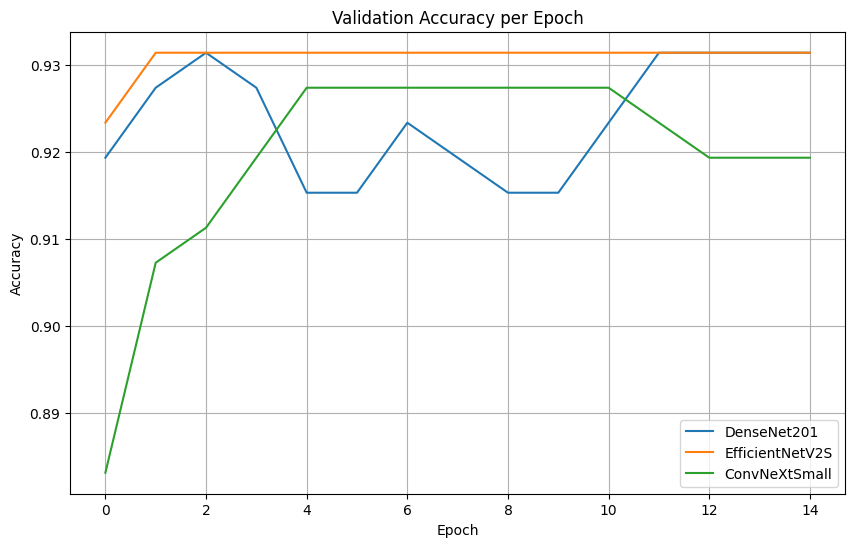

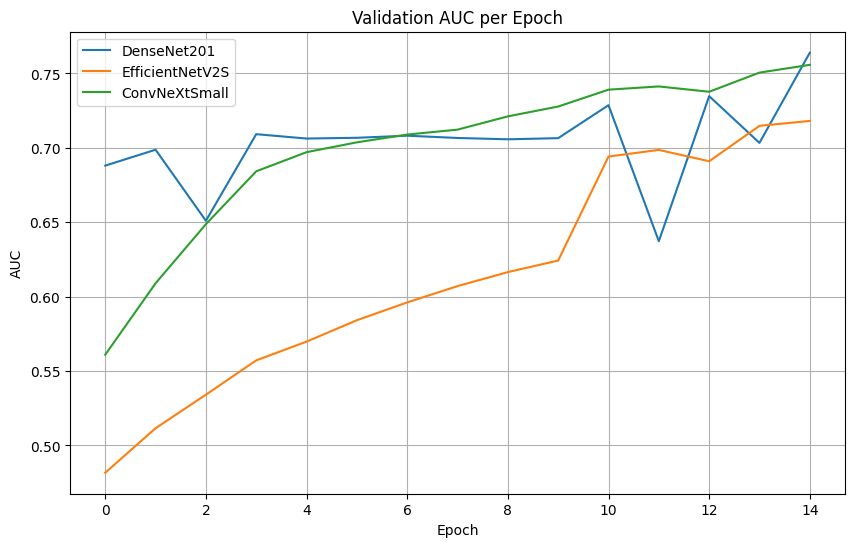

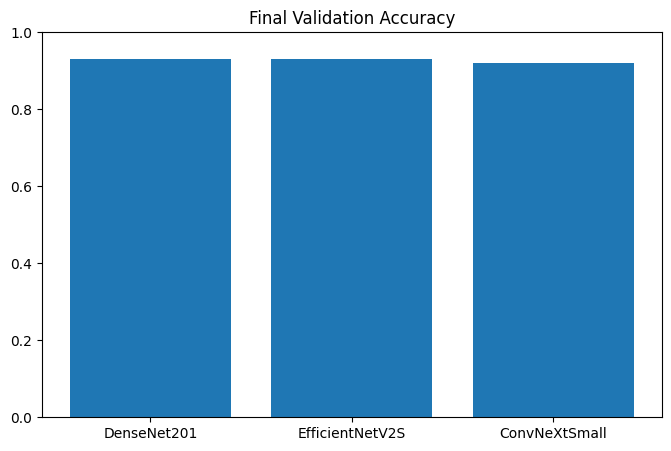

In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# -----------------------------
# Config
# -----------------------------
DATA_DIR = "/content/drive/MyDrive/processed_images"  # 👈 change this
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10   # frozen training
FT_EPOCHS = 5 # fine-tuning
VAL_SPLIT = 0.2
SEED = 42

# -----------------------------
# Data pipeline
# -----------------------------
train_ds = keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=VAL_SPLIT,
    subset="training",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

val_ds = keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=VAL_SPLIT,
    subset="validation",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

# Data augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# -----------------------------
# Build classifier
# -----------------------------
def build_model(backbone_fn, name):
    base = backbone_fn(weights="imagenet", include_top=False,
                       input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base.trainable = False
    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = data_augmentation(inputs)
    x = keras.applications.imagenet_utils.preprocess_input(x)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs, name=name)
    model.compile(
        optimizer=keras.optimizers.Adam(1e-4),
        loss="binary_crossentropy",
        metrics=["accuracy", keras.metrics.AUC(name="auc")]
    )
    return model, base

# -----------------------------
# Fine-tune function
# -----------------------------
def finetune_model(model, base, unfreeze_layers=30, lr=1e-6, epochs=10):
    base.trainable = True

    # Freeze everything except last `unfreeze_layers`
    for layer in base.layers[:-unfreeze_layers]:
        layer.trainable = False

    # Keep BatchNorm frozen
    for layer in base.layers:
        if isinstance(layer, layers.BatchNormalization):
            layer.trainable = False

    model.compile(
        optimizer=keras.optimizers.Adam(lr),
        loss="binary_crossentropy",
        metrics=["accuracy", keras.metrics.AUC(name="auc")]
    )
    print(f"✅ Fine-tuning last {unfreeze_layers} layers with LR={lr}")
    return model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=1)


# -----------------------------
# Backbones from TF/Keras
# -----------------------------
from tensorflow.keras.applications import (
    DenseNet201,
    EfficientNetV2S,
    ConvNeXtSmall,
)

backbones = {
    "DenseNet201": DenseNet201,
    "EfficientNetV2S": EfficientNetV2S,
    "ConvNeXtSmall": ConvNeXtSmall,
}

# -----------------------------
# Train & Evaluate
# -----------------------------
histories = {}
results = {}

for name, fn in backbones.items():
    print(f"\n=== Training {name} (frozen) ===")
    model, base = build_model(fn, name)

    # Phase 1: frozen training
    h1 = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, verbose=1)

    # Phase 2: fine-tuning (unfreeze last half of layers)
    h2 = finetune_model(model, base,
                        unfreeze_layers=len(base.layers)//2,
                        lr=1e-5,
                        epochs=FT_EPOCHS)

    # Combine histories
    combined_hist = {k: h1.history[k] + h2.history[k] for k in h1.history.keys()}
    histories[name] = combined_hist

    # Evaluate final
    loss, acc, auc = model.evaluate(val_ds, verbose=0)
    results[name] = {"acc": acc, "auc": auc}
    print(f"{name} → Acc={acc:.4f}, AUC={auc:.4f}")

# -----------------------------
# Plot performance
# -----------------------------
plt.figure(figsize=(10,6))
for name,h in histories.items():
    plt.plot(h["val_accuracy"], label=name)
plt.title("Validation Accuracy per Epoch")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,6))
for name,h in histories.items():
    plt.plot(h["val_auc"], label=name)
plt.title("Validation AUC per Epoch")
plt.xlabel("Epoch"); plt.ylabel("AUC")
plt.legend(); plt.grid(True); plt.show()

# Final bar chart
plt.figure(figsize=(8,5))
plt.bar(results.keys(), [v["acc"] for v in results.values()])
plt.title("Final Validation Accuracy")
plt.ylim(0,1); plt.show()